# imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import wradlib as wrl
import datetime
from pyproj import Transformer
from osgeo import osr
import re
from tqdm import tqdm

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

# Data and variables

In [16]:
# DIR_vedur = 'C:/Users/sverrirhd/vedurgogn/'
DIR_vedur = 'F:/'
# DIR_vedur = 'G:/'
DIR_save = 'F:/CAPPI/'
# DIR_save = 'C:/Users/sverrirhd/OneDrive/CAPPI/'

df_meta = pd.read_csv('./Analysis/file_metadata.csv',index_col=0)
df_meta.url = df_meta.url.str.replace('C:/Users/sverrirhd/vedurgogn//',DIR_vedur)
df_meta.ctime = pd.to_datetime(df_meta.ctime)
df_meta.loc[:,'year and month'] = df_meta.ctime.apply(lambda x : str(x.year) + '%02d' % x.month)
months = df_meta.loc[:,'year and month'].sort_index().values
month_urls = glob(DIR_vedur + '/radar/[0-9]*')

proj = osr.SpatialReference()
proj.ImportFromEPSG(3057)

0

# Metadata that matters for later:
- Variables that relate to radar-rainfall estimation:
    - gain
    - nodata
    - offset
    - etc. 

# For H5 files

In [17]:
# List of all h5 files
df_meta_h5 = df_meta.loc[df_meta.loc[:,'extension'] == '.H5']
df_meta_h5_group_lists = df_meta_h5.groupby('ctime').apply(lambda x: list(x.index))


In [18]:

# starting strategy
current_strategy = np.array([ 0.5,  0.9,  1.3,  2.4,  3.5,  4.5,  6. ,  8. , 10. , 15. , 25. , 40. ])

# For experimentation
single_scan_indexes = df_meta_h5_group_lists[0]
single_scan = df_meta.loc[single_scan_indexes]
single_scan = single_scan.sort_values('angle')

# find elevation angles
n_scans = len(single_scan)
elangles = single_scan.angle.values

# find coordinates from each scan (Likely redundant)
tmp_urls = single_scan.loc[:,'url'].values
raw_list = [wrl.io.read_generic_hdf5(i) for i in tmp_urls]

sitecoords_list = []
for raw in raw_list:
    sitecoords = (raw["where"]['attrs']["lon"], raw["where"]['attrs']["lat"],
            raw["where"]['attrs']["height"])
    sitecoords_list.append(sitecoords)
    print(raw['scan1/data']['data'].max())
    
# check that they are all the same    
assert np.all(np.array(sitecoords_list) == sitecoords_list[0])

255
157
160
157
152
150
142
130
123
112
69
66


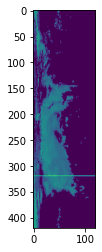

In [19]:
plt.imshow(raw_list[0]['scan1/data']['data'])

In [20]:
# F:/radar\201501\NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5

In [21]:
(df_meta.iloc[0,0]) # 'F:/radar\\201501\\NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5'

'F:/radar\\201501\\NORPOL240_MIDNESHE_00_5_20150101_0000_O.H5'

## Help function for old filetype strategy extraction

In [22]:
def get_new_gridder(raw_list):
    elangles = []
    xyz = np.array([]).reshape((-1, 3))
    data = np.array([])
    
    for i,raw in enumerate(raw_list):
        # Radar strategy
        elangle = raw['where']['attrs']['angle']
        n_az = raw['where']['attrs']['ysize']
        n_range = raw['where']['attrs']['xsize']
        rscale = raw['where']['attrs']['xscale']
        rstart = 1  #  Unsure about this
        
        
        elangles.append(elangle)
        az = np.arange(0., 360., 360. / n_az)
        rstart = rstart * 1000.
        r = np.arange(rstart,
                    rstart + n_range * rscale,
                    rscale)
        xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, elangle, az, r, proj)
        
        
        # Data 
        gain = raw['scan1/what']['attrs']['gain']
        offset = raw['scan1/what']['attrs']['offset']
        raw_data = raw['scan1/data']['data']
        data_ = offset + gain * raw_data
        
        xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())
    
    # generate 3-D Cartesian target grid coordinates
    maxrange = 250_000. #meters?
    minelev = np.min(elangles) # degrees?
    maxelev = np.max(elangles) # degrees?
    maxalt = 12000. # metere?
    horiz_res = 833.
    vert_res = 100.
    desired_height = 1250

    trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords  = sitecoords,
                                            proj = proj,
                                            maxrange = maxrange,
                                            maxalt = maxalt,
                                            horiz_res = horiz_res,
                                            vert_res = vert_res)

    CAPPI_layer_idx = int((desired_height - 0)/(maxalt - 0) * trgshape[0])

    trgxyz_subset = trgxyz.reshape(list(trgshape) + [3])[CAPPI_layer_idx]
    trgxyz_subset = trgxyz_subset.reshape(-1,3)

    gridder = wrl.vpr.PseudoCAPPI(polcoords = xyz,
                            gridcoords = trgxyz_subset,
                            gridshape = trgshape[1:], 
                            maxrange = maxrange,
                            minelev = minelev,
                            maxelev = maxelev)

    # vol = np.ma.masked_invalid(gridder(data).reshape(trgshape[1:]))

    return gridder,trgshape


In [23]:
gridder_dict = {}
trgshape_dict = {}

In [24]:
# df_meta_h5_group_lists.loc[missing_dates[:,0]]

In [25]:
# Monthly indicators for filtering
df_start_end = pd.concat([df_meta_h5.groupby('year and month').min().loc[:,'ctime'],df_meta_h5.groupby('year and month').max().loc[:,'ctime']],axis=1)
df_start_end.columns = ['start','end']

# initialization so the variables are defined outside the scope of the for loop
gridder, trgshape = None,None 
current_strategy = list() # No starting strategy

# one month at a time for easier debugging
for index,row in df_start_end.iterrows():
    # Names for checking and saving
    URL_CAPPI = f'{DIR_save}CAPPI_{index}.npy'
    URL_mask = f'{DIR_save}CAPPI_MASK_{index}.npy'
    URL_urls = f'{DIR_save}urls{index}.npy'
    URL_problematic_indexes = f'{DIR_save}problematic_indexes{index}.npy'
    URL_descriptive_data = f'{DIR_save}descriptive_data{index}.npy'
    
    # Check if it already exists
    len_URL_CAPPI = len(glob(URL_CAPPI)) > 0
    len_URL_mask = len(glob(URL_mask)) > 0
    len_URL_urls = len(glob(URL_urls)) > 0
    len_URL_problematic_indexes = len(glob(URL_problematic_indexes)) > 0
    len_URL_descriptive_data = len(glob(URL_descriptive_data)) > 0
    if all([
        len_URL_CAPPI,
        len_URL_mask,
        len_URL_urls,
        len_URL_problematic_indexes,
        len_URL_descriptive_data
        ]):
        continue
    # timestamps for first and last images of month
    start = row['start']
    end = row['end']
    
    # Subset of month
    monthly_subset = df_meta_h5_group_lists.loc[start:end]

    len_subset = len(monthly_subset)
    monthly_vols = []
    monthly_masks = []
    urls = []
    problematic_indexes = []
    descriptive_data = {}
    # Iterate over radar slices
    pbar = tqdm(range(len_subset))
    pbar.set_description("Processing %s" % index)
    for indx,single_scan_indexes in zip(pbar,monthly_subset):
        # if indx % 25 == 0:        
        #     print(f'{indx} of {len_subset}',end='\r')
        single_scan = df_meta.loc[single_scan_indexes]
        single_scan = single_scan.sort_values('angle')
        # find elevation angles
        n_scans = len(single_scan)
        elangles = list(single_scan.angle.values)
        elangle_string = str(elangles)
        
        # Stop the run if the angles have changed
        if (elangle_string not in gridder_dict.keys()) or (elangle_string not in trgshape_dict.keys()):
            print('new strategy:',elangles)
            gridder,trgshape = get_new_gridder(raw_list)
            gridder_dict[elangle_string] = gridder
            trgshape_dict[elangle_string] = trgshape
            

        if elangles != current_strategy:
            print('new strategy:',elangles)
            gridder,trgshape = get_new_gridder(raw_list)
            current_strategy = elangles

        # Can crash if a file is corrupted
        tmp_urls = single_scan.url
        try:
            raw_list = [wrl.io.read_generic_hdf5(i) for i in tmp_urls]
        except KeyboardInterrupt: # for early stopping
            print('I tried!')
            assert False
        except:
            print('I tried - but was misunderstood!')
            problematic_indexes.append(single_scan_indexes)
            continue # just skip the whole thing
        

        data = []
        descriptive_data_tmp = {}
        for i,raw in enumerate(raw_list):
            # Data 
            gain = raw['scan1/what']['attrs']['gain']
            offset = raw['scan1/what']['attrs']['offset']
            raw_data = raw['scan1/data']['data']
            descriptive_data_tmp[i] = {}
            descriptive_data_tmp[i]['gain'] = gain
            descriptive_data_tmp[i]['offset'] = offset
            data.append(raw_data)
            
        data = np.array(data,dtype=float)
        data[data == 255] = np.nan

        descriptive_data[index] = descriptive_data_tmp
        # compute CAPPI
        vol = np.ma.masked_invalid(gridder(data.ravel()).reshape(trgshape[1:]))
        mask = np.ma.getmask(vol)
        
        # only save these together so one isn't without the other
        monthly_vols.append(vol)
        monthly_masks.append(mask)
        urls.append(tmp_urls) 

    CAPPI_tensor = np.round(np.array(monthly_vols),0).astype('uint8')
    CAPPI_tensor_mask = np.array(monthly_masks)
    
    np.save(URL_CAPPI,CAPPI_tensor,allow_pickle=True)
    np.save(URL_mask,CAPPI_tensor_mask,allow_pickle=True)
    np.save(URL_urls,urls,allow_pickle=True)
    ############### 
    np.save(URL_problematic_indexes,problematic_indexes,allow_pickle=True)
    np.save(URL_descriptive_data,descriptive_data,allow_pickle=True)
    #6.59it/s - 07:31

Processing 201612:   0%|          | 0/2931 [00:00<?, ?it/s]

new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 15.0, 25.0, 40.0]
new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 15.0, 25.0, 40.0]


Processing 201612:  41%|████      | 1190/2931 [01:16<01:49, 15.95it/s]

new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]
new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]


Processing 201612:  41%|████      | 1198/2931 [01:21<08:04,  3.58it/s]

new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 15.0, 25.0, 40.0]


Processing 201612:  48%|████▊     | 1409/2931 [01:36<01:21, 18.58it/s]

I tried - but was misunderstood!


Processing 201701:  73%|███████▎  | 2166/2976 [04:55<01:25,  9.43it/s]

I tried - but was misunderstood!


Processing 201702:  12%|█▏        | 313/2687 [00:44<04:30,  8.77it/s]

I tried - but was misunderstood!


Processing 201703:  92%|█████████▏| 2670/2912 [05:48<00:41,  5.82it/s]

new strategy: [0.5, 0.9, 1.3, 2.4, 3.5, 4.5, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0]


Processing 201707:  23%|██▎       | 690/2976 [01:26<04:17,  8.87it/s]

I tried - but was misunderstood!


Processing 201707:  85%|████████▍ | 2527/2976 [05:30<00:51,  8.68it/s]

I tried - but was misunderstood!


Processing 201708:  32%|███▏      | 963/2974 [02:06<03:49,  8.76it/s]

I tried - but was misunderstood!


Processing 201708:  42%|████▏     | 1252/2974 [02:43<03:38,  7.87it/s]

I tried - but was misunderstood!


Processing 201709:  45%|████▍     | 1264/2840 [02:50<02:56,  8.95it/s]

I tried - but was misunderstood!


Processing 201709:  99%|█████████▉| 2824/2840 [06:31<00:01,  8.83it/s]

I tried - but was misunderstood!


Processing 201712:  56%|█████▌    | 1671/2971 [03:56<02:27,  8.81it/s]

I tried - but was misunderstood!


Processing 201802:  71%|███████   | 1875/2645 [04:34<01:42,  7.53it/s]

I tried - but was misunderstood!


Processing 201803:  21%|██▏       | 410/1908 [01:18<05:30,  4.53it/s]

I tried - but was misunderstood!


Processing 201803: 100%|██████████| 1908/1908 [06:12<00:00,  5.12it/s]


## Sanity check - if processing looks ok

In [26]:
# import cv2
# import os

# image_folder = 'images'
# video_name = 'video.avi'

# # images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# # frame = cv2.imread(os.path.join(image_folder, images[0]))
# height, width, layers = monthly_vols_matrix[0].shape

# video = cv2.VideoWriter(video_name, 0, 1, (width,height))

# for i,image in enumerate(monthly_vols_matrix[:100]):
#     scaled_image = (image + 31) / (140)
#     scaled_image = np.array(scaled_image)
#     scaled_image[np.isnan(scaled_image)] = 0
#     plt.imshow(scaled_image)
#     plt.savefig(f'./images/image_{i}.png')
#     # plt.show()
#     # video.write(scaled_image)

# cv2.destroyAllWindows()
# video.release()

In [27]:
elangles = []

xyz = np.array([]).reshape((-1, 3))
data = np.array([])
for i,raw in enumerate(raw_list):
    print(i)
    
    # Radar strategy
    elangle = raw['where']['attrs']['angle']
    n_az = raw['where']['attrs']['ysize']
    n_range = raw['where']['attrs']['xsize']
    rscale = raw['where']['attrs']['xscale']
    rstart = 1  #  Unsure about this
    
    
    elangles.append(elangle)
    az = np.arange(0., 360., 360. / n_az)
    rstart = rstart * 1000.
    r = np.arange(rstart,
                  rstart + n_range * rscale,
                  rscale)
    xyz_ = wrl.vpr.volcoords_from_polar(sitecoords, elangle, az, r, proj)
    
    
    # Data 
    gain = raw['scan1/what']['attrs']['gain']
    offset = raw['scan1/what']['attrs']['offset']
    raw_data = raw['scan1/data']['data']
    data_ = offset + gain * raw_data
    
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, data_.ravel())
    
    


0
1
2
3
4
5
6
7
8
9
10
11


In [28]:
# xyz.mean(axis=0)

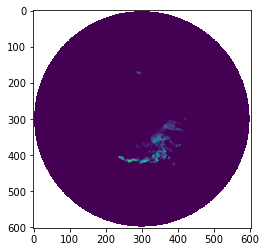

In [29]:
# generate 3-D Cartesian target grid coordinates
maxrange = 250_000. #meters?
minelev = np.min(elangles) # degrees?
maxelev = np.max(elangles) # degrees?
maxalt = 12000. # metere?
horiz_res = 833.
vert_res = 100.


trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords  = sitecoords,
                                    proj = proj,
                                    maxrange = maxrange,
                                    maxalt = maxalt,
                                    horiz_res = horiz_res,
                                    vert_res = vert_res)

CAPPI_layer_idx = int((2000 - 0)/(maxalt - 0) * trgshape[0]) # 2000 meters

trgxyz_subset = trgxyz.reshape(list(trgshape) + [3])[CAPPI_layer_idx]
trgxyz_subset = trgxyz_subset.reshape(-1,3)

gridder = wrl.vpr.PseudoCAPPI(polcoords = xyz,
                        gridcoords = trgxyz_subset,
                        gridshape = trgshape[1:], 
                        maxrange = maxrange,
                        minelev = minelev,
                        maxelev = maxelev)

vol = np.ma.masked_invalid(gridder(data).reshape(trgshape[1:]))
plt.imshow(vol)

In [30]:
# np.save('CAPPI_pixel_coords.npy',trgxyz_subset)

In [31]:
# import geopandas as gpd
# sitecoords = (-22.636, 64.025, 45.0)

# postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')
# coords = trgxyz_subset# np.load('../Radar processing/CAPPI_pixel_coords.npy')

# transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
# transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

# radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
# gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)


# radar_width_in_image = (602*240/250+1)
# pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
# idx_closest_pixel = pixel_distance.argmin()
# pixel_distance[idx_closest_pixel],idx_closest_pixel
# gauge_idx,gauge_idy = idx_closest_pixel//602,idx_closest_pixel%602

In [32]:
# ((np.array([radar_x - gauge_x,radar_y - gauge_y])**2).sum())**0.5

In [33]:
# margin = 10

# CAPPI_indexes = np.arange(602**2).reshape(602,602)
# cappi_idx = CAPPI_indexes[gauge_idx-margin:gauge_idx+margin,gauge_idy-margin:gauge_idy+margin].ravel()

# plt.figure(figsize=(15,15))
# pixels_handle = plt.scatter(coords[cappi_idx,0],coords[cappi_idx,1],s = 100,marker = 's',edgecolors='black')

# postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')

# radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)
# gauge_handle = plt.scatter(gauge_x,gauge_y,c ='red',marker = '*',s = 90)

# plt.scatter(475151.43, 537577.96)
# plt.scatter(537577.96,475151.43)
# # plt.ylim(gauge_y - 30_000,gauge_y + 20_000)
# # plt.xlim(gauge_x - 50_000,gauge_x + 20_000)
# # plt.xticks([],[])
# # plt.yticks([],[])
# plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview',fontsize=25)
# plt.legend([radar_handle,gauge_handle,pixels_handle],['Radar','Primary Rain-gauge','CAPPI pixels'],loc = 'upper left',fontsize=15)
# plt.show()

In [34]:
meta_data = dict()
meta_data_0 = raw_list[0]['scan1/what']['attrs']
meta_data_1 = raw_list[0]['how']['attrs']
meta_data_2 = raw_list[0]['what']['attrs']

meta_data.update(meta_data_0)
meta_data.update(meta_data_1)
meta_data.update(meta_data_2)
meta_data

{'gain': 0.4,
 'nodata': 255.0,
 'offset': -30.0,
 'product': b'SCAN',
 'quantity': b'DBZ',
 'startdate': b'20180321',
 'starttime': b'000114',
 'stopdate': b'20180321',
 'stoptime': b'000144',
 'undetect': 0.0,
 'WMO': 2334,
 'azmethod': b'RANDOM',
 'beamwidth': 0.9,
 'binmethod': b'AVERAGE',
 'doppler': 0,
 'highprf': 250,
 'lowprf': 250,
 'place': b'Keflavik',
 'pulsewidth': 2.0,
 'radar_fail': 0,
 'radar_msg': b'f94 4f9 000 000 8ff:',
 'rpm': 2.0,
 'software': b'PARTEC2',
 'system': b'ERIC',
 'wavelength': 5.35,
 'date': b'20180320',
 'object': b'SCAN',
 'sets': 1,
 'time': b'235500',
 'version': b'H5rad 1.2'}

In [35]:
df_meta.loc[:,'extension'] 

0                .H5
1                .H5
2                .H5
3                .H5
4                .H5
             ...    
1625949    .vol.hdf5
1625950    .vol.hdf5
1625951    .vol.hdf5
1625952    .vol.hdf5
1625953    .vol.hdf5
Name: extension, Length: 1625463, dtype: object

# For hdf5 files

In [36]:
df_meta_hdf5 = df_meta.loc[df_meta.loc[:,'extension'] == '.vol.hdf5']
df_meta_hdf5_group_lists = df_meta_hdf5.groupby('ctime').apply(lambda x: list(x.index))


In [37]:
# starting strategy
current_strategy = np.array([ 0.5,  0.9,  1.3,  2.4,  3.5,  4.5,  6. ,  8. , 10. , 15. , 25. , 40. ])


In [38]:
# For experimentation
single_scan_indexes = df_meta_hdf5_group_lists[0]
single_scan = df_meta.loc[single_scan_indexes]
single_scan = single_scan.sort_values('angle')

# find elevation angles
n_scans = len(single_scan)

# find coordinates from each scan (redundant for unified files)
tmp_urls = single_scan.loc[:,'url'].values
raw_list = [wrl.io.read_generic_hdf5(i) for i in tmp_urls]

sitecoords_list = []
for raw in raw_list:
    sitecoords = (raw["where"]['attrs']["lon"], raw["where"]['attrs']["lat"],
            raw["where"]['attrs']["height"])
    sitecoords_list.append(sitecoords)
    
# check that they are all the same    
assert np.all(np.array(sitecoords_list) == sitecoords_list[0])

In [39]:
# Monthly indicators for filtering
df_start_end = pd.concat([df_meta_hdf5.groupby('year and month').min().loc[:,'ctime'],df_meta_hdf5.groupby('year and month').max().loc[:,'ctime']],axis=1)
df_start_end.columns = ['start','end']

# initialization so the variables are defined outside the scope of the for loop
gridder, trgshape = None,None 
current_strategy = list() # No starting strategy


## Helper functions

In [40]:
def get_hdf5_elangles(raw):
    wherelist = [i for i in raw.keys() if len(re.findall('dataset[0-9]*/where',i)) > 0]
    elangles = sorted([raw[wherekey]['attrs']['elangle'] for wherekey in wherelist])
    return elangles

def get_hdf5_data(raw):
    datalist = np.array([i for i in raw.keys() if len(re.findall('dataset[0-9]*/data1/data',i)) > 0])
    data_order = [int(re.findall('dataset[0-9]*/',data_name)[0][7:-1]) for data_name in datalist]
    data_argsort = np.argsort(data_order)
    sorted_data = datalist[data_argsort]
    data_list = [raw[datakey]['data'] for datakey in sorted_data]
    
    # This is just for consistency with other data insertion method
    data =  np.array([])
    for data_ in data_list:
        data = np.append(data, data_.ravel())
    
    return data


In [41]:

def get_new_gridder_hdf5(raw):
    elangles = []
    xyz = np.array([]).reshape((-1, 3))
    data = np.array([])

    elangles = get_hdf5_elangles(raw)
    n_scans = len(elangles)

    for i in range(n_scans):
        # get the scan metadata for each elevation
        where = raw["dataset%d/where" % (i + 1)]['attrs']
        what = raw["dataset%d/data1/what" % (i + 1)]['attrs']

        az = np.arange(0., 360., 360. / where["nrays"])
        rstart = where["rstart"] * 1000.
        r = np.arange(rstart,
                      rstart + where["nbins"] * where["rscale"],
                      where["rscale"])

        # derive 3-D Cartesian coordinate tuples
        xyz_ = wrl.vpr.volcoords_from_polar(
            sitecoords, where["elangle"], az, r, proj)
        xyz = np.vstack((xyz, xyz_))

    # generate 3-D Cartesian target grid coordinates
    maxrange = 250_000. #meters?
    minelev = np.min(elangles) # degrees?
    maxelev = np.max(elangles) # degrees?
    maxalt = 12000. # metere?
    horiz_res = 833.
    vert_res = 100.
    desired_height = 1250

    
    
    trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords  = sitecoords,
                                        proj = proj,
                                        maxrange = maxrange,
                                        maxalt = maxalt,
                                        horiz_res = horiz_res,
                                        vert_res = vert_res)
    
    # CAPPI_layer_idx = int((2000 - 0)/(maxalt - 0) * trgshape[0]) # 2000 meters
    CAPPI_layer_idx = int((desired_height - 0)/(maxalt - 0) * trgshape[0])

    trgxyz_subset = trgxyz.reshape(list(trgshape) + [3])[CAPPI_layer_idx]
    trgxyz_subset = trgxyz_subset.reshape(-1,3)

    gridder = wrl.vpr.PseudoCAPPI(polcoords = xyz,
                            gridcoords = trgxyz_subset,
                            gridshape = trgshape[1:], 
                            maxrange = maxrange,
                            minelev = minelev,
                            maxelev = maxelev)
    
    return gridder,trgshape

In [42]:
gridder_dict = {}
trgshape_dict = {}

In [43]:
# one month at a time for easier debugging
for index,row in df_start_end.iterrows():
    # print(index)
    URL_CAPPI = f'{DIR_save}CAPPI_{index}_hdf5.npy'
    URL_mask = f'{DIR_save}CAPPI_MASK_{index}_hdf5.npy'
    URL_urls = f'{DIR_save}urls{index}_hdf5.npy'
    URL_problematic_indexes = f'{DIR_save}problematic_indexes{index}_hdf5.npy'
    URL_descriptive_data = f'{DIR_save}descriptive_data{index}_hdf5.npy'
    
    if len(glob(URL_descriptive_data)) > 0:
        continue
    
    # timestamps for first and last images of month
    start = row['start']
    end = row['end']    
    
    # Subset of month
    monthly_subset = df_meta_hdf5_group_lists.loc[start:end]

    len_subset = len(monthly_subset)
    monthly_vols = []
    monthly_masks = []
    urls = []
    problematic_indexes = []
    descriptive_data = {}

    n_subset = len(monthly_subset)
    # Iterate over radar slices
    
    pbar = tqdm(range(n_subset))
    pbar.set_description("Processing %s" % index)
    for indx,single_scan_indexes in zip(pbar,monthly_subset):
        
        # print(indx,indx % 25 == 0)
        single_scan = df_meta.loc[single_scan_indexes]
        single_scan = single_scan.sort_values('angle')
        
        # find coordinates from each scan (Likely redundant)
        tmp_urls = single_scan.loc[:,'url'].values
        
        # Can crash if a file is corrupted
        try:
            raw = wrl.io.read_generic_hdf5(tmp_urls[0])
        except KeyboardInterrupt: # for early stopping
            assert False
        except: # For other kinds of errors
            # problematic_indexes.append(single_scan_indexes)
            continue # just skip the whole thing
        
        # find elevation angles
        elangles = get_hdf5_elangles(raw)
        n_scans = len(elangles)
        elangle_string = str(elangles)
        
        if (elangle_string not in gridder_dict.keys()) or (elangle_string not in trgshape_dict.keys()):
            # print('new strategy:',elangles)
            gridder,trgshape = get_new_gridder_hdf5(raw)
            gridder_dict[elangle_string] = gridder
            trgshape_dict[elangle_string] = trgshape
            
        gridder = gridder_dict[elangle_string]
        trgshape = trgshape_dict[elangle_string]
        
        
        data = get_hdf5_data(raw)
        data[data == 255] = np.nan
        vol = np.ma.masked_invalid(gridder(data).reshape(trgshape[1:]))
        mask = np.ma.getmask(vol)
        vol = np.round(np.array(vol),0).astype('uint8')
        
        # only save these together so one isn't without the other
        monthly_vols.append(vol)
        monthly_masks.append(mask)
        urls.append(tmp_urls) 
        
    CAPPI_tensor = np.round(np.array(monthly_vols),0).astype('uint8')
    CAPPI_tensor_mask = np.array(monthly_masks)
    

    np.save(URL_CAPPI,CAPPI_tensor,allow_pickle=True)
    np.save(URL_mask,CAPPI_tensor_mask,allow_pickle=True)
    np.save(URL_urls,urls,allow_pickle=True)
    np.save(URL_problematic_indexes,problematic_indexes,allow_pickle=True)
    np.save(URL_descriptive_data,descriptive_data,allow_pickle=True)

    data = None
    gridder = None
    trgshape = None
    vol = None
    mask = None
    CAPPI_tensor = None
    CAPPI_tensor_mask = None
    monthly_masks = None
    monthly_vols = None
    urls = None
    problematic_indexes = None
    descriptive_data = None

Processing 202011: 100%|██████████| 8632/8632 [15:48:51<00:00,  6.60s/it] 


FileNotFoundError: [Errno 2] No such file or directory: 'F:/CAPPI/CAPPI_202011_hdf5.npy'

In [ ]:
get_new_gridder_hdf5(raw)

In [ ]:
raw['dataset1/where']

In [ ]:
raw.keys()

In [ ]:
raw = raw_list[0]




In [ ]:
data = np.array([])

descriptive_data_tmp = {}
for i,raw in enumerate(raw_list):
    # Data 
    gain = raw['scan1/what']['attrs']['gain']
    offset = raw['scan1/what']['attrs']['offset']
    raw_data = raw['scan1/data']['data']
    descriptive_data_tmp[i] = {}
    descriptive_data_tmp[i]['gain'] = gain
    descriptive_data_tmp[i]['offset'] = offset
    
    # data_ = offset + gain * raw_data
    data_ = raw_data # For cheaper storage
    
    data = np.append(data, data_.ravel())

In [ ]:
100*20

# Sanity check for CAPPI

In [ ]:
# generate 3-D Cartesian target grid coordinates
maxrange = 250_000. #meters?
minelev = np.min(elangles) # degrees?
maxelev = np.max(elangles) # degrees?
maxalt = 12000. # metere?
horiz_res = 833.
vert_res = 100.


trgxyz, trgshape = wrl.vpr.make_3d_grid(sitecoords  = sitecoords,
                                    proj = proj,
                                    maxrange = maxrange,
                                    maxalt = maxalt,
                                    horiz_res = horiz_res,
                                    vert_res = vert_res)

CAPPI_layer_idx = int((2000 - 0)/(maxalt - 0) * trgshape[0]) # 2000 meters

trgxyz_subset = trgxyz.reshape(list(trgshape) + [3])[CAPPI_layer_idx]
trgxyz_subset = trgxyz_subset.reshape(-1,3)

gridder = wrl.vpr.PseudoCAPPI(polcoords = xyz,
                        gridcoords = trgxyz,
                        gridshape = trgshape, 
                        maxrange = maxrange,
                        minelev = minelev,
                        maxelev = maxelev)

vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))


In [ ]:
vol.shape

In [ ]:
f,axes = plt.subplots(11,11,figsize=(30,30))
for i,(ax,layer) in enumerate(zip(axes.ravel(),vol)):
    ax.imshow(layer)
    ax.set_title(i)
plt.show()

In [ ]:
for i,layer in enumerate(vol):
    plt.imshow(layer)
    plt.title(i)
    plt.savefig(f'./images/cappi_tests/CAPPI_slices_{i}.png')

In [ ]:
df_start_end.loc[['201711']]

# Check for missing data

In [ ]:
# Monthly indicators for filtering
df_start_end = pd.concat([df_meta_h5.groupby('year and month').min().loc[:,'ctime'],df_meta_h5.groupby('year and month').max().loc[:,'ctime']],axis=1)
df_start_end.columns = ['start','end']

# initialization so the variables are defined outside the scope of the for loop
gridder, trgshape = None,None 
current_strategy = list() # No starting strategy

raw_data_list = []
raw_full_file_list = []

# one month at a time for easier debugging
for index,row in df_start_end.loc[['201711']].iterrows():
    # print(index)
    # URL_CAPPI = f'{DIR_save}CAPPI_{index}.npy'
    # URL_urls = f'{DIR_save}urls{index}.npy'
    # URL_problematic_indexes = f'{DIR_save}problematic_indexes{index}.npy'
    # URL_descriptive_data = f'{DIR_save}descriptive_data{index}.npy'
    
    # if len(glob(URL_descriptive_data)) > 0:
    #     continue
    
    # timestamps for first and last images of month
    start = row['start']
    end = row['end']
    
    # Subset of month
    monthly_subset = df_meta_h5_group_lists.loc[start:end]
    print()
    len_subset = len(monthly_subset)
    monthly_vols = []
    urls = []
    problematic_indexes = []
    descriptive_data = {}
    # Iterate over radar slices
    for indx,single_scan_indexes in enumerate(monthly_subset):
        if indx % 25 == 0:        
            print(f'{indx} of {len_subset}',end='\r')
        single_scan = df_meta.loc[single_scan_indexes]
        single_scan = single_scan.sort_values('angle')
        tmp_urls = single_scan.loc[:,'url'].values
        
        # find elevation angles
        n_scans = len(single_scan)
        elangles = list(single_scan.angle.values)
        
        # Stop the run if the angles have changed
        if elangles != current_strategy:
            print('new strategy:',elangles)
            gridder,trgshape = get_new_gridder(raw_list)
            current_strategy = elangles
        
        # Can crash if a file is corrupted
        try:
            raw_list = [wrl.io.read_generic_hdf5(i) for i in tmp_urls]
        except KeyboardInterrupt: # for early stopping
            assert False
        except: # For other kinds of errors
            problematic_indexes.append(single_scan_indexes)
            continue # just skip the whole thing
        
        data = np.array([])
        
        descriptive_data_tmp = {}
        for i,raw in enumerate(raw_list):
            # Data 
            gain = raw['scan1/what']['attrs']['gain']
            offset = raw['scan1/what']['attrs']['offset']
            raw_data = raw['scan1/data']['data']
            descriptive_data_tmp[i] = {}
            descriptive_data_tmp[i]['gain'] = gain
            descriptive_data_tmp[i]['offset'] = offset
            
            # data_ = offset + gain * raw_data
            data_ = raw_data # For cheaper storage
            
            data = np.append(data, data_.ravel())
            
        descriptive_data[index] = descriptive_data_tmp
        # compute CAPPI At 2km
        vol = np.ma.masked_invalid(gridder(data).reshape(trgshape[1:]))
        raw_data_list.append(data)
        raw_full_file_list.append(raw_list)
        
    #     # only save these together so one isn't without the other
    #     monthly_vols.append(vol)
    #     urls.append(tmp_urls) 
    # # except:
        
    # CAPPI_tensor = np.round(np.array(monthly_vols),0).astype('uint8')

    
    # np.save(URL_CAPPI,CAPPI_tensor)
    # np.save(URL_urls,urls)
    # np.save(URL_problematic_indexes,problematic_indexes)
    # np.save(URL_descriptive_data,descriptive_data)

In [ ]:
raw_data = np.array(raw_data_list)

In [ ]:
len(raw_data)

In [ ]:
argwhere_tmp = np.argwhere(raw_data == 255)

In [ ]:
argwhere_tmp[12240]

In [ ]:
(argwhere_tmp[:,1]/(420*120)).argmin()

In [ ]:
np.argwhere(raw_data == 255)/raw_data.shape[1],np.argwhere(raw_data == 255)%raw_data.shape[1]

In [ ]:
raw_data.min()

In [ ]:
len(raw_full_file_list)

In [ ]:
argwhere_tmp

In [ ]:
for i,sl in enumerate(raw_full_file_list[2483]):
    max_value = sl['scan1/data']['data'].max()
    print(i,max_value)

In [ ]:
plt.imshow(raw_full_file_list[2483][2]['scan1/data']['data'])

In [ ]:
raw_data.ravel().shape

In [ ]:
# del no_missing
no_missing = raw_data[raw_data<218]

In [ ]:
np.sum(no_missing>180)

In [ ]:
no_missing_2

In [ ]:
hist_vals = plt.hist(raw_data.ravel(),bins = np.arange(0,256))
plt.yscale('log')

In [ ]:
plt.plot(hist_vals[0])
plt.yscale('log')

In [ ]:
list(zip(hist_vals[0],hist_vals[1]))

In [ ]:
plt.imshow(raw_full_file_list[467][9]['scan1/data']['data'])

In [ ]:
plt.imshow(raw_full_file_list[467][9]['scan1/data']['data'])

In [ ]:
# one month at a time for easier debugging

raw_data_list = []
raw_list = []
for index,row in df_start_end.loc['201711':].iterrows():
    # print(index)
    URL_CAPPI = f'{DIR_save}CAPPI_{index}_hdf5.npy'
    URL_urls = f'{DIR_save}urls{index}_hdf5.npy'
    URL_problematic_indexes = f'{DIR_save}problematic_indexes{index}_hdf5.npy'
    URL_descriptive_data = f'{DIR_save}descriptive_data{index}_hdf5.npy'
    
    if len(glob(URL_descriptive_data)) > 0:
        continue
    
    # timestamps for first and last images of month
    start = row['start']
    end = row['end']    
    
    # Subset of month
    monthly_subset = df_meta_hdf5_group_lists.loc[start:end]

    len_subset = len(monthly_subset)
    monthly_vols = []
    urls = []
    problematic_indexes = []
    descriptive_data = {}

    n_subset = len(monthly_subset)
    # Iterate over radar slices
    
    pbar = tqdm(range(n_subset))
    pbar.set_description("Processing %s" % index)
    for indx,single_scan_indexes in zip(pbar,monthly_subset):
        
        # print(indx,indx % 25 == 0)
        single_scan = df_meta.loc[single_scan_indexes]
        single_scan = single_scan.sort_values('angle')
        
        # find coordinates from each scan (Likely redundant)
        tmp_urls = single_scan.loc[:,'url'].values
        
        # Can crash if a file is corrupted
        try:
            raw = wrl.io.read_generic_hdf5(tmp_urls[0])
        except KeyboardInterrupt: # for early stopping
            assert False
        except: # For other kinds of errors
            problematic_indexes.append(single_scan_indexes)
            continue # just skip the whole thing
        
        # find elevation angles
        elangles = get_hdf5_elangles(raw)
        n_scans = len(elangles)
        elangle_string = str(elangles)
        
        if (elangle_string not in gridder_dict.keys()) or (elangle_string not in trgshape_dict.keys()):
            # print('new strategy:',elangles)
            gridder,trgshape = get_new_gridder_hdf5(raw)
            gridder_dict[elangle_string] = gridder
            trgshape_dict[elangle_string] = trgshape
            
        gridder = gridder_dict[elangle_string]
        trgshape = trgshape_dict[elangle_string]
        
        
        data = get_hdf5_data(raw)
        raw_data_list.append(data)
        raw_list.append(raw)
    #     vol = np.ma.masked_invalid(gridder(data).reshape(trgshape[1:]))
        
    #     # only save these together so one isn't without the other
    #     monthly_vols.append(vol)
    #     urls.append(tmp_urls) 
        
    # CAPPI_tensor = np.round(np.array(monthly_vols),0).astype('uint8')

    # np.save(URL_CAPPI,CAPPI_tensor)
    # np.save(URL_urls,urls)
    # np.save(URL_problematic_indexes,problematic_indexes)
    # np.save(URL_descriptive_data,descriptive_data)